In [1]:
# run if ModuleNotFoundError occurs, then use the path output to install modules
import sys
print(sys.executable) 

/usr/local/Cellar/jupyterlab/3.0.14/libexec/bin/python3.9


### Functions for Data Loading and Plotting

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math, random
import scipy.optimize
import scipy.stats as stats
import seaborn as sns
import re

sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [7.0, 4.5]

data_dir = "results/"

def load_benchmark(filename):
    data = []
    row = [0, 0, 0, 0]
    with open(data_dir + filename, "r") as f:
        for line in f:
            words = line.split(" ")
            if line.startswith("Switches successful:"):
                row = [0, 0, 0, 0]
                row[0] = float(words[2].replace("%", ""))
            elif line.startswith("Runtime:"):
                row[1] = float(words[1].replace("s", ""))
            elif line.startswith("Switches per second:"):
                row[2] = float(words[3].replace("M", ""))
            elif line.startswith("Estimated randomization time:"):
                row[3] = float(words[3].replace("s", ""))
                data.append(row)
    data = pd.DataFrame(data, columns=["ss", "rt", "sps", "ert"])
    return data

def fieller_ci(a, b, a_std, b_std, a_N, b_N, alpha=0.025):
    ratio = a / b
    a_var = a_std * a_std
    b_var = b_std * b_std
    df = a_N + b_N - 2
    t = 2
    g = t * t * b_var / (b * b)
    if g >= 1:
        return None, None
    ratio_std = ratio / (1 - g) * math.sqrt((1 - g) * a_var / (a * a) + b_var / (b * b))
    lower = ratio / (1 - g) - t * ratio_std
    upper = ratio / (1 - g) + t * ratio_std
    return lower, upper

print(stats.t.interval(1 - 0.05, 20))
print(stats.t.interval(1 - 0.10, 20))

(-2.0859634472658364, 2.0859634472658364)
(-1.7247182429207863, 1.7247182429207857)


In [140]:
def plot_comparison(name):
    data = None
    sequential = load_benchmark(name + "_robin_10_1").ert.mean()
    sequential_std = load_benchmark(name + "_robin_10_1").ert.std()
    sequential_N = load_benchmark(name + "_robin_10_1").ert.size
    for p in [2, 4, 8, 16]:
        for algo in ["naive", "global", "global-no-wait"]:
            ert = load_benchmark(name + "_" + algo + "_10_" + str(p)).ert.mean()
            std = load_benchmark(name + "_" + algo + "_10_" + str(p)).ert.std()
            N = load_benchmark(name + "_" + algo + "_10_" + str(p)).ert.size
            speedup = sequential / ert
            lower, upper = fieller_ci(sequential, ert, sequential_std, std, sequential_N, N)
            if algo == "naive":
                algo_name = "$\mathtt{Naive}$"
            elif algo == "global":
                algo_name = "$\mathtt{Global}$"
            elif algo == "global-no-wait":
                algo_name = "$\mathtt{Wait-Free-Global}$"
            data_algo_p = pd.DataFrame([[algo_name, p, ert, speedup, lower, upper]], columns=["Algorithm", "PUs", "ert", "speedup", "lower", "upper"])
            if p == 2 and algo == "naive":
                data = data_algo_p
            else:
                data = pd.concat([data, data_algo_p])
    fig, ax = plt.subplots()
    algo_colors = ["$\mathtt{Naive}$", "$\mathtt{Global}$", "$\mathtt{Wait-Free-Global}$"]
    g_results=sns.lineplot(x="PUs", y="speedup", data=data, hue='Algorithm', hue_order=algo_colors)
    for algo in algo_colors:
        ax.fill_between(x=data.loc[data["Algorithm"] == algo, "PUs"],
                        y1=data.loc[data["Algorithm"] == algo, "lower"],
                        y2=data.loc[data["Algorithm"] == algo, "upper"], alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[0:], labels=labels[0:])
    g_results.set(xlabel='number of PUs $p$', ylabel='speed-up', title=name)
    g_results.get_figure().savefig("figures/" + str(name) + ".pdf", format='pdf', dpi=1200, bbox_inches="tight")

### Running-time in dependence of n

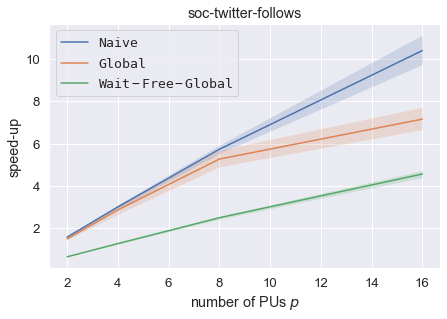

In [141]:
plot_comparison("soc-twitter-follows")

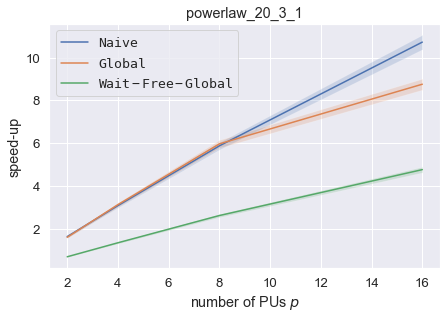

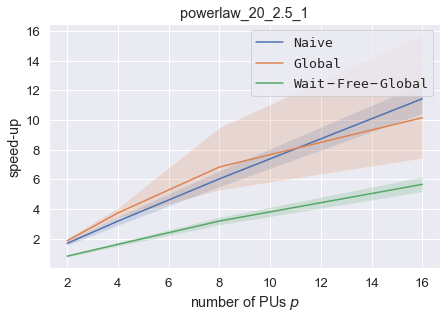

In [146]:
plot_comparison("powerlaw_20_3_1")
plot_comparison("powerlaw_20_2.5_1")
#plot_comparison("powerlaw_20_2_1")